### Understanding the data

In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

In [2]:
filenames = glob("*.csv")

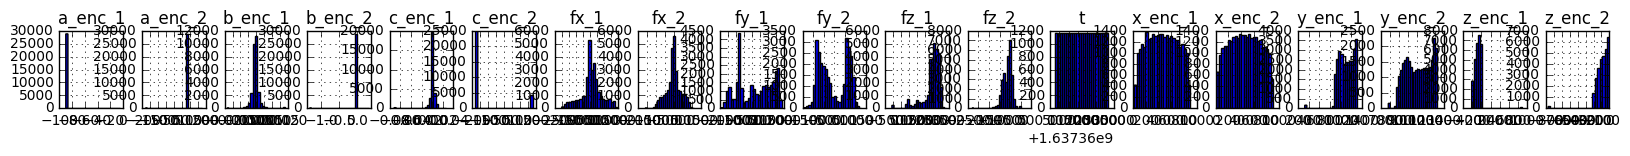

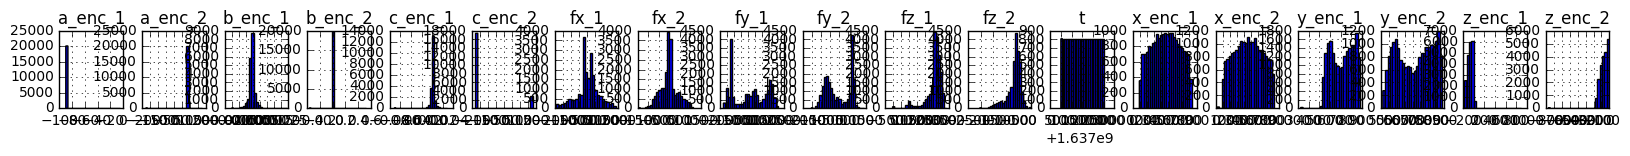

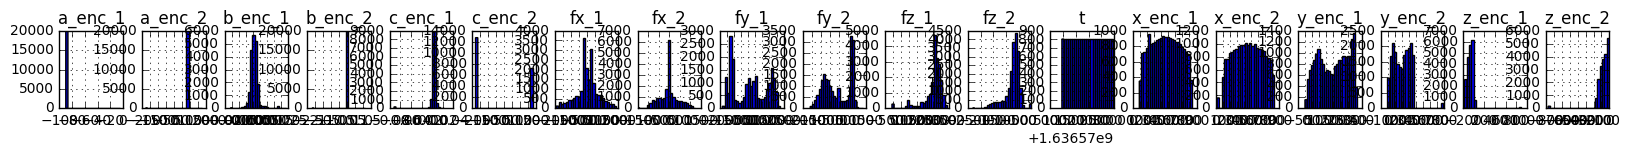

In [3]:
# (Very) rough sanity check, we'll assume training runs are comparable
for f in filenames:
    pd.read_csv(f).hist(bins=25, layout=(1, 19), figsize=((20,1)))
plt.show()

In [4]:
df = pd.concat((pd.read_csv(f) for f in filenames), ignore_index=True)

In [5]:
df.head()

,a_enc_1,a_enc_2,b_enc_1,b_enc_2,c_enc_1,c_enc_2,fx_1,fx_2,fy_1,fy_2,fz_1,fz_2,t,x_enc_1,x_enc_2,y_enc_1,y_enc_2,z_enc_1,z_enc_2
0,-4.9512,-154.9772,0.0183,0.2024,-0.0719,-179.8798,-3.032278,9.523903,10.828661,18.360941,-50.630136,-4.349339,1637362767,213.633300,22.320400,324.099000,783.175400,895.3528,-772.5771
1,-4.9511,-154.9772,0.0183,0.2024,-0.0719,-179.8798,-2.943760,9.388515,10.469587,18.410955,-50.269871,-3.943046,1637362768,213.633700,22.320400,324.101500,783.175400,895.3528,-772.5771
2,-4.9512,-154.9772,0.0183,0.2024,-0.0719,-179.8798,-2.877008,9.207934,10.641118,17.434249,-51.787233,-1.858033,1637362769,213.633301,22.320400,324.099008,783.175400,895.3528,-772.5771
3,-4.9510,-154.9772,0.0183,0.2024,-0.0719,-179.8798,-3.104533,9.114192,10.679307,18.594151,-50.673054,-2.520182,1637362770,213.634199,22.320396,324.103994,783.175400,895.3528,-772.5771
4,-4.9511,-154.9773,0.0183,0.2024,-0.0719,-179.8798,-3.147975,8.791884,10.443695,18.243160,-50.880316,-4.777954,1637362771,213.633699,22.318711,324.101492,783.174405,895.3528,-772.5771


#### Input features:
Entities: Encoder 1, Encoder 2

Attributes: *a, b, c* (pitch, yaw, roll); and *x, y, z* (position, with metal along x/y plane)

#### Predictions:
Entities: Tool tip 1, Tool tip 2

Attributes: *fx, fy, fz* (forces along respective positions)

#### Assumptions:
- Treating each point independently from one another
- All three given training runs are comparable (joining all data together)

In [6]:
# Labels
y_full = df.loc[:, 'fx_1':'fz_2']
y_full.head()

,fx_1,fx_2,fy_1,fy_2,fz_1,fz_2
0,-3.032278,9.523903,10.828661,18.360941,-50.630136,-4.349339
1,-2.943760,9.388515,10.469587,18.410955,-50.269871,-3.943046
2,-2.877008,9.207934,10.641118,17.434249,-51.787233,-1.858033
3,-3.104533,9.114192,10.679307,18.594151,-50.673054,-2.520182
4,-3.147975,8.791884,10.443695,18.243160,-50.880316,-4.777954


In [7]:
x_full = df.drop(['t', 'fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)

In [8]:
x_full.head()

,a_enc_1,a_enc_2,b_enc_1,b_enc_2,c_enc_1,c_enc_2,x_enc_1,x_enc_2,y_enc_1,y_enc_2,z_enc_1,z_enc_2
0,-4.9512,-154.9772,0.0183,0.2024,-0.0719,-179.8798,213.633300,22.320400,324.099000,783.175400,895.3528,-772.5771
1,-4.9511,-154.9772,0.0183,0.2024,-0.0719,-179.8798,213.633700,22.320400,324.101500,783.175400,895.3528,-772.5771
2,-4.9512,-154.9772,0.0183,0.2024,-0.0719,-179.8798,213.633301,22.320400,324.099008,783.175400,895.3528,-772.5771
3,-4.9510,-154.9772,0.0183,0.2024,-0.0719,-179.8798,213.634199,22.320396,324.103994,783.175400,895.3528,-772.5771
4,-4.9511,-154.9773,0.0183,0.2024,-0.0719,-179.8798,213.633699,22.318711,324.101492,783.174405,895.3528,-772.5771


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2)

### Normalize data

In [10]:
# min-max normalization, using x_train, y_train as references
xn_train = (x_train - x_train.min())/(x_train.max()-x_train.min())
xn_test  = (x_test  - x_train.min())/(x_train.max()-x_train.min())

# NOTE: remember to undo normalization after predictions
yn_train = (y_train - y_train.min())/(y_train.max()-y_train.min())
yn_test  = (y_test  - y_train.min())/(y_train.max()-y_train.min())

### Random Forest Classifier

In [11]:
rf = RandomForestRegressor().fit(xn_train, yn_train)

In [12]:
# Resulting prediction score (coefficient of determiniation) using held-out test set:
rf.score(xn_test, yn_test)

0.98561216037849075

In [13]:
yn_predict = rf.predict(xn_test)

# And mean-squared error:
MSE(yn_test, yn_predict)

0.0005268919216820571

In [14]:
# get unnormalized force predictions:
y_predict = np.multiply(yn_predict,(y_train.max()-y_train.min()).tolist()) + y_train.min().tolist()

pd.DataFrame(y_predict, columns=y_test.columns).head()

,fx_1,fx_2,fy_1,fy_2,fz_1,fz_2
0,1658.210568,-666.179922,-321.542862,226.412288,2859.273631,-447.057837
1,224.917258,-691.449097,325.119413,-459.532008,1952.483372,-1709.729935
2,109.667407,48.091505,1849.360188,-844.699620,2792.617107,-424.975078
3,-142.801463,2.587083,-1046.875176,625.925602,2641.650371,-789.417441
4,-986.933710,585.469216,1259.679454,-804.420965,3013.031217,-635.523897


In [15]:
y_test.head()

,fx_1,fx_2,fy_1,fy_2,fz_1,fz_2
38251,1667.451673,-644.588468,-373.388292,238.960125,2845.682211,-441.039018
51065,195.797710,-681.593566,337.403412,-417.502745,2014.695671,-1810.045019
36497,32.864349,83.311011,1878.321117,-892.451128,2798.738506,-439.317428
46636,-193.682180,-156.687034,-1140.010845,854.179840,2762.625637,-968.530169
32680,-1024.655320,544.990998,1058.710209,-803.458153,2901.366307,-588.086115


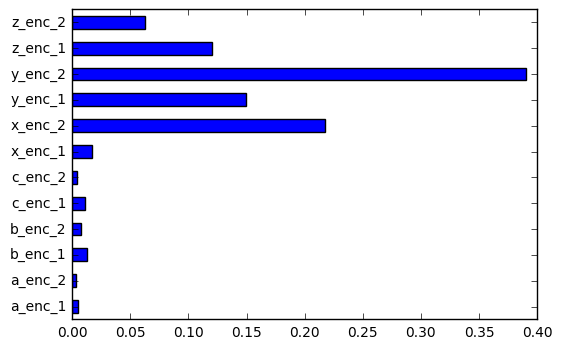

In [16]:
# Consider feature importances:
feat_vals = pd.Series(rf.feature_importances_, index=x_full.columns)
feat_vals.plot(kind='barh')
plt.show()

Of the given input features, encoder positions appears to more significantly impact force than their orientations.

### Additional Considerations
* May want to consider as a time series, not all independent points
* Can look at more appropriate normalization schemes?
* Other regression models
* Classification scheme?
* Consider force features together, not independently?
* Create additional features by combining existing inputs?
* Feature analysis to limit less important features